In [ ]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import time
import matplotlib.pyplot as plt
import math


In [40]:
def prepare_tensors(X, y, test_size=0.3, random_state=42):
    """Converts NumPy arrays into PyTorch tensors and performs train-test split."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if len(set(y)) > 1 else None
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # 🔹 Change to `torch.float32`
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)  # 🔹 Change to `torch.float32`

    input_dim = X_train_tensor.shape[1]
    output_dim = 1  # 🔹 Should be 1 for binary classification with BCE loss

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, output_dim

In [41]:
# ------------------------------
def create_dummy_data():
    # 10 datapoints, 2 features each
    X = torch.tensor([
        [0.1, 0.2],
        [0.2, 0.1],
        [0.4, 0.2],
        [0.2, 0.3],
        [0.9, 0.8],
        [0.8, 0.9],
        [0.3, 0.2],
        [0.5, 0.6],
        [0.6, 0.5],
        [0.7, 0.8]
    ], dtype=torch.float32)
    # Binary labels: 1 if sum > 0.8, else 0.
    y = (X.sum(dim=1) > 0.8).float()
    input_dim, output_dim = X.shape[1], 1
    return X, y, input_dim, output_dim 

In [42]:
# # # Cancer
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     # Load the dataset
#     df = pd.read_csv(file_path)
#     print("Loaded dataset with shape:", df.shape)

#     # Define target and feature columns correctly
#     target_col = "diagnosis"
#     feature_cols = df.columns[2:]  # Exclude 'id' (first column) and take features from column 3 onward

#     # Extract features (X) and target labels (y)
#     X = df[feature_cols].values
#     y = df[target_col].values

#     # Encode 'diagnosis' column ('M' -> 1, 'B' -> 0)
#     le = LabelEncoder()
#     y = le.fit_transform(y)  # Converts "M"/"B" to 1/0

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Check for NaNs and replace if necessary
#     if np.isnan(X_scaled).any():
#         print("⚠️ Warning: NaNs found in dataset! Replacing with zeros.")
#         X_scaled = np.nan_to_num(X_scaled)

#     # Print class distribution
#     unique, counts = np.unique(y, return_counts=True)
#     print("Class Distribution:", dict(zip(unique, counts)))

#     # Ensure valid test size
#     min_class_samples = min(counts)
#     test_size = min(0.3, max(0.1, (min_class_samples - 1) / len(y)))

#     # Perform train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_scaled, y, test_size=test_size, random_state=random_state, stratify=y if min_class_samples > 1 else None
#     )
#     # Convert to PyTorch tensors **before checking for NaNs**
#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

#     X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
#     y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

#     # Now it's safe to check for NaNs
#     print("NaNs in X_train:", torch.isnan(X_train_tensor).sum().item())
#     print("NaNs in y_train:", torch.isnan(y_train_tensor).sum().item())


#     input_dim = X_train_tensor.shape[1]
#     output_dim = 1  # Binary classification, should be 1 for Pyro's Bernoulli

#     return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, output_dim

In [43]:
# # heart
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     df = pd.read_csv(file_path)
#     print("Loaded Heart dataset with shape:", df.shape)

#     # Define target and feature columns
#     target_col = "target"
#     feature_cols = df.columns[:-1]  # All columns except target

#     # Extract features and target
#     X = df[feature_cols].values
#     y = df[target_col].values

#     # Standardize numerical features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     # Train-test split
#     return prepare_tensors(X, y, test_size, random_state)


In [44]:
# diabetis
def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
    df = pd.read_csv(file_path)
    print("Loaded Diabetes dataset with shape:", df.shape)

    # Define target and feature columns
    target_col = "Outcome"
    feature_cols = df.columns[:-1]  # All except target

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[feature_cols].values)

    y = df[target_col].values

    # Train-test split
    return prepare_tensors(X, y, test_size, random_state)


In [45]:
# # heart_statlog_cleveland_hungary_final
# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     df = pd.read_csv(file_path)
#     print("Loaded Heart (Statlog + Cleveland + Hungary) dataset with shape:", df.shape)

#     # Define target and feature columns
#     target_col = "target"
#     feature_cols = df.columns[:-1]  # All except target

#     # Convert multiclass labels (1, 2, 3, 4) → Binary classification (1: Disease, 0: No Disease)
#     df[target_col] = df[target_col].apply(lambda x: 1 if x > 0 else 0)

#     # Standardize features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(df[feature_cols].values)

#     y = df[target_col].values

#     # Train-test split
#     return prepare_tensors(X, y, test_size, random_state)

In [46]:
# # hepatitis

# def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
#     df = pd.read_csv(file_path, na_values="?")
#     print("Loaded Hepatitis dataset with shape:", df.shape)

#     # Define target and feature columns
#     target_col = "out_class"
#     feature_cols = df.columns[1:]

#     # Convert target labels (2 → 1 "Survived", 1 → 0 "Died")
#     df["out_class"] = df["out_class"].replace({2: 1, 1: 0})

#     # Convert binary categorical features (1 → 0 "No", 2 → 1 "Yes")
#     binary_cols = ["sex", "steroid", "antivirals", "fatigue", "malaise", "anorexia",
#                    "liver_big", "liver_firm", "spleen_palable", "spiders", "ascites",
#                    "varices", "histology"]
#     df[binary_cols] = df[binary_cols].replace({1: 0, 2: 1})

#     # Fill missing values with column means
#     df.fillna(df.mean(), inplace=True)

#     # Standardize numerical features
#     numerical_cols = ["age", "bilirubin", "alk_phosphate", "sgot", "albumin", "protime"]
#     scaler = StandardScaler()
#     df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

#     # Extract features and target
#     X = df[feature_cols].values
#     y = df["out_class"].values

#     # Train-test split
#     return prepare_tensors(X, y, test_size, random_state)


In [47]:
class BoostingVINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=3):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim


    def model(X, y=None):
        batch_size = X.shape[0]
        input_dim = X.shape[1]      # dynamically get number of input features
        hidden_dim = 3              # or set this as a parameter
        # First layer: weights shape (input_dim, hidden_dim) and biases shape (hidden_dim)
        w1 = pyro.sample("w1", dist.Normal(torch.zeros(input_dim, hidden_dim), torch.ones(input_dim, hidden_dim)).to_event(2))
        b1 = pyro.sample("b1", dist.Normal(torch.zeros(hidden_dim), torch.ones(hidden_dim)).to_event(1))
        # Second layer: weights shape (hidden_dim, 1) and bias scalar
        w2 = pyro.sample("w2", dist.Normal(torch.zeros(hidden_dim, 1), torch.ones(hidden_dim, 1)).to_event(2))
        b2 = pyro.sample("b2", dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
        
        hidden = torch.relu(torch.matmul(X, w1) + b1)
        logits = torch.matmul(hidden, w2) + b2
        pyro.deterministic("logits", logits.squeeze(-1))
        probs = torch.sigmoid(logits).squeeze(-1)
        
        with pyro.plate("data", batch_size):
            pyro.sample("obs", dist.Bernoulli(probs), obs=y)


    def boosted_guide(X, y=None, index=0):
        input_dim = X.shape[1]
        hidden_dim = 3  # or parameterize this as needed
        
        w1_loc = pyro.param(f"w1_loc_{index}", torch.zeros(input_dim, hidden_dim))
        w1_scale = pyro.param(f"w1_scale_{index}", torch.ones(input_dim, hidden_dim), constraint=dist.constraints.positive)
        b1_loc = pyro.param(f"b1_loc_{index}", torch.zeros(hidden_dim))
        b1_scale = pyro.param(f"b1_scale_{index}", torch.ones(hidden_dim), constraint=dist.constraints.positive)
        
        w2_loc = pyro.param(f"w2_loc_{index}", torch.zeros(hidden_dim, 1))
        w2_scale = pyro.param(f"w2_scale_{index}", torch.ones(hidden_dim, 1), constraint=dist.constraints.positive)
        b2_loc = pyro.param(f"b2_loc_{index}", torch.tensor(0.0))
        b2_scale = pyro.param(f"b2_scale_{index}", torch.tensor(1.0), constraint=dist.constraints.positive)
        
        pyro.sample("w1", dist.Normal(w1_loc, w1_scale).to_event(2))
        pyro.sample("b1", dist.Normal(b1_loc, b1_scale).to_event(1))
        pyro.sample("w2", dist.Normal(w2_loc, w2_scale).to_event(2))
        pyro.sample("b2", dist.Normal(b2_loc, b2_scale))

            

        # ------------------------------
    # 4. Define the Custom RELBO Objective
    # ------------------------------
    def relbo(model, guide, X, y=None, approximation=None):
        # Compute the standard ELBO loss using the current guide component
        traced_guide = poutine.trace(guide).get_trace(X, y)
        elbo = Trace_ELBO(max_plate_nesting=1)
        loss = elbo.differentiable_loss(model, guide, X, y)
        
        # Use the current approximation (mixture of previous components) to compute its log-probability.
        # We block the latent names so that previous components are not updated.
        replayed_approx = poutine.trace(
            poutine.replay(
                poutine.block(approximation, expose=["w1", "b1", "w2", "b2"]),
                traced_guide
            )
        ).get_trace(X, y)
        
        relbo_value = -loss - replayed_approx.log_prob_sum()
        # SVI minimizes the loss so we return negative of relbo_value.
        return -relbo_value

    # ------------------------------
    # 5. Define the Mixture Approximation
    #    This function samples a component according to mixture weights and calls its guide.
    # ------------------------------
    def approximation(X, y, components, weights):
        assignment = pyro.sample("assignment", dist.Categorical(weights))
        return components[assignment.item()](X, y)
    
    # 🔹 Fix: Implement `forward()` to avoid `NotImplementedError`
    def forward(self, X):
        return self.model(X)


In [48]:

# ------------------------------
# 6. Boosted Training Loop
# ------------------------------
def train_boosted_model(X, y,input_dim, output_dim, n_iterations=2, n_steps=2000):
    pyro.clear_param_store()
    
    # Start with an initial component (index=0)
    initial_component = partial(BoostingVINN.boosted_guide, index=0)
    # Make y optional in the lambda wrapper (defaulting to None)
    components = [lambda X, y=None: initial_component(X, y)]
    weights = torch.tensor([1.0])
    wrapped_approximation = partial(BoostingVINN.approximation, components=components, weights=weights)
    
    optimizer_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    
    # For tracking weights over iterations
    mixture_weights_history = [weights.clone()]
    
    for t in range(1, n_iterations + 1):
        print(f"\nBoosting iteration {t}")
        new_component = partial(BoostingVINN.boosted_guide, index=t)
        # Wrap to standardize the signature with an optional y.
        wrapped_new_component = lambda X, y=None, comp=new_component: comp(X, y)
        
        optimizer = Adam(optimizer_params)
        svi = SVI(BoostingVINN.model, wrapped_new_component, optimizer,
                  loss=partial(BoostingVINN.relbo, approximation=wrapped_approximation))
        losses = []
        for step in range(n_steps):
            loss = svi.step(X, y)
            losses.append(loss)
            if step % 500 == 0:
                print(f"Step {step}: Loss = {loss}")
        print(f"Component {t} training complete. Final loss: {losses[-1]:.2f}")
        
        # Append the new guide component to our mixture
        components.append(wrapped_new_component)
        # Update the mixture weights; here a simple rule is used.
        new_weight = 2.0 / (t + 1)
        if t == 2:
            new_weight = 0.5  # special case for demonstration
        weights = weights * (1 - new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))
        wrapped_approximation = partial(BoostingVINN.approximation, components=components, weights=weights)
        print(f"Updated mixture weights: {weights.tolist()}")
        
        mixture_weights_history.append(weights.clone())
    return components, weights, mixture_weights_history

In [49]:
def calculate_nll(probs, y, epsilon=1e-8):
    """
    Calculate the Negative Log Likelihood (NLL) for binary classification.
    
    Args:
        probs (torch.Tensor): Predicted probabilities (values between 0 and 1).
        y (torch.Tensor): True binary labels (0 or 1).
        epsilon (float): Small constant to avoid log(0).

    Returns:
        torch.Tensor: The computed NLL value.
    """
    nll = - torch.mean(y * torch.log(probs + epsilon) + (1 - y) * torch.log(1 - probs + epsilon))
    return nll

def calculate_ece(probs, y, n_bins=10):
    """
    Calculate the Expected Calibration Error (ECE).
    
    Args:
        probs (torch.Tensor): Predicted probabilities.
        y (torch.Tensor): True binary labels.
        n_bins (int): Number of bins to use for calibration.

    Returns:
        float: The computed ECE.
    """
    # Convert tensors to numpy arrays for easier manipulation
    probs_np = probs.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    total_samples = len(probs_np)
    
    # For each bin, compute the weighted absolute difference between accuracy and confidence.
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        bin_mask = (probs_np >= bin_lower) & (probs_np < bin_upper)
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            avg_confidence = np.mean(probs_np[bin_mask])
            avg_accuracy = np.mean(y_np[bin_mask])
            bin_weight = bin_count / total_samples
            ece += np.abs(avg_confidence - avg_accuracy) * bin_weight
    return ece


In [50]:
# Modified evaluation function to include NLL and ECE computation.
def evaluate_boosted_model(X, y, components, weights, num_samples=1000):
    aggregated_preds = None
    for i, comp in enumerate(components):
        predictive = Predictive(BoostingVINN.model, guide=comp, num_samples=num_samples)
        samples = predictive(X)
        # Get the average predicted probability over the samples
        pred_probs = torch.sigmoid(samples["logits"]).mean(0)
        if aggregated_preds is None:
            aggregated_preds = weights[i] * pred_probs
        else:
            aggregated_preds += weights[i] * pred_probs

    # Ensure aggregated_preds is one-dimensional
    aggregated_preds = aggregated_preds.squeeze()

    # Convert probabilities to binary predictions
    final_preds = (aggregated_preds > 0.5).float()
    accuracy = (final_preds == y).float().mean().item()
    print("Boosted Model Accuracy: {:.2f}%".format(accuracy * 100))
    
    # Calculate and print Negative Log Likelihood (NLL)
    nll_value = calculate_nll(aggregated_preds, y)
    print("Negative Log Likelihood (NLL): {:.4f}".format(nll_value.item()))
    
    # Calculate and print Expected Calibration Error (ECE)
    ece_value = calculate_ece(aggregated_preds, y, n_bins=10)
    print("Expected Calibration Error (ECE): {:.4f}".format(ece_value))
    
    print("Aggregated Predictions (Probabilities):", aggregated_preds)
    print("True Labels:", y)


In [51]:
# # ------------------------------
# # 7. Evaluation Function for the Boosted Model
# # ------------------------------
# def evaluate_boosted_model(X, y, components, weights, num_samples=1000):
#     # Aggregate predictions over the mixture components using their weights.
#     aggregated_preds = None
#     for i, comp in enumerate(components):
#         predictive = Predictive(model, guide=comp, num_samples=num_samples)
#         # Note: we call with y omitted (defaulting to None)
#         samples = predictive(X)
#         # Average the deterministic logits (passed through sigmoid) to get probabilities.
#         pred_probs = torch.sigmoid(samples["logits"]).mean(0)
#         if aggregated_preds is None:
#             aggregated_preds = weights[i] * pred_probs
#         else:
#             aggregated_preds += weights[i] * pred_probs
#     final_preds = (aggregated_preds > 0.5).float()
#     accuracy = (final_preds == y).float().mean().item()
#     print("Boosted Model Accuracy: {:.2f}%".format(accuracy * 100))
#     print("Aggregated Predictions:", final_preds)
#     print("True Labels:", y)
# ------------------------------
# 8. Plotting Function for Mixture Weights
# ------------------------------
def plot_mixture_weights(mixture_weights_history):
    # Use the final mixture weights for a bar plot.
    final_weights = mixture_weights_history[-1].detach().cpu().numpy()
    components_idx = np.arange(len(final_weights))
    
    plt.figure(figsize=(6, 4))
    plt.bar(components_idx, final_weights, color='skyblue')
    plt.xlabel("Boosting Component Index")
    plt.ylabel("Mixture Weight")
    plt.title("Mixture Weights of Boosting VI Components")
    plt.xticks(components_idx)
    plt.show()




def plot_mixture_weights_evolution(mixture_weights_history):
    """
    Plots how mixture weights evolve over boosting iterations.
    
    mixture_weights_history: List of 1D tensors, each containing the mixture weights after an iteration.
    """
    num_iterations = len(mixture_weights_history)
    fig, axes = plt.subplots(1, num_iterations, figsize=(4 * num_iterations, 4), sharey=True)

    # Handle the case where there is only one iteration
    if num_iterations == 1:
        axes = [axes]  # Make it a list for consistent indexing

    for i, weights_tensor in enumerate(mixture_weights_history):
        ax = axes[i]
        weights = weights_tensor.detach().cpu().numpy()
        components_idx = np.arange(len(weights))
        ax.bar(components_idx, weights, color='skyblue')
        ax.set_xlabel("Component Index")
        ax.set_ylabel("Mixture Weight")
        ax.set_title(f"Iteration {i+1}")
        ax.set_xticks(components_idx)

    plt.suptitle("Evolution of Mixture Weights in Boosting VI")
    plt.tight_layout()
    plt.show()

def plot_1d_boosting_vi(
    components_params,  # list of (mu, sigma) for each component
    weights,            # final mixture weights, shape [num_components]
    true_dist_fn=None,  # callable: true_dist_fn(x) returns p(x)
    x_min=-5, x_max=5, num_points=500
):
    """
    Plot a 1D mixture approximation vs. an optional true distribution.
    
    components_params: a list of (mu_i, sigma_i) for i in [0, n_components-1]
    weights: array-like or tensor of mixture weights summing to 1
    true_dist_fn: function that maps x-values to the true PDF
    x_min, x_max: range of x-values to plot
    num_points: resolution for the plot
    """
    x_grid = np.linspace(x_min, x_max, num_points)
    mixture_pdf = np.zeros_like(x_grid)

    # Build mixture pdf = sum_i [ w_i * Normal(mu_i, sigma_i).pdf(x) ]
    for (mu, sigma), w in zip(components_params, weights):
        # Evaluate Normal PDF
        comp_pdf = (1.0 / (sigma * np.sqrt(2.0 * math.pi))) * \
                   np.exp(-0.5 * ((x_grid - mu) / sigma)**2)
        mixture_pdf += w * comp_pdf

    plt.figure(figsize=(8, 5))
    # Plot the mixture approximation
    plt.plot(x_grid, mixture_pdf, color='red', lw=2, label='Boosting VI Approx')

    # Plot the true distribution if provided
    if true_dist_fn is not None:
        true_pdf = true_dist_fn(x_grid)
        plt.plot(x_grid, true_pdf, color='black', lw=2, linestyle='--', label='True Posterior')

    plt.title("Boosting VI vs. True Posterior in 1D")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


Loaded Diabetes dataset with shape: (768, 9)

Boosting iteration 1
Step 0: Loss = 663.5350341796875
Step 500: Loss = 275.03662109375
Step 1000: Loss = 257.6562194824219
Step 1500: Loss = 251.5601806640625
Component 1 training complete. Final loss: 244.39
Updated mixture weights: [0.0, 1.0]

Boosting iteration 2
Step 0: Loss = 1152.4573974609375
Step 500: Loss = -1246.7763671875
Step 1000: Loss = -1866133667840.0
Step 1500: Loss = -1.10622515781427e+20
Component 2 training complete. Final loss: -294746222795400675328.00
Updated mixture weights: [0.0, 0.5, 0.5]
Training time for BVI NN: 53.3159 seconds
Boosted Model Accuracy: 75.23%
Negative Log Likelihood (NLL): 0.5557
Expected Calibration Error (ECE): 0.1360
Aggregated Predictions (Probabilities): tensor([0.5490, 0.3843, 0.4868, 0.3247, 0.4664, 0.5528, 0.4927, 0.2494, 0.5290,
        0.2452, 0.2439, 0.5398, 0.2873, 0.5325, 0.5342, 0.5419, 0.5233, 0.2903,
        0.5344, 0.5479, 0.2582, 0.5229, 0.3729, 0.3565, 0.3271, 0.2952, 0.5312,
  

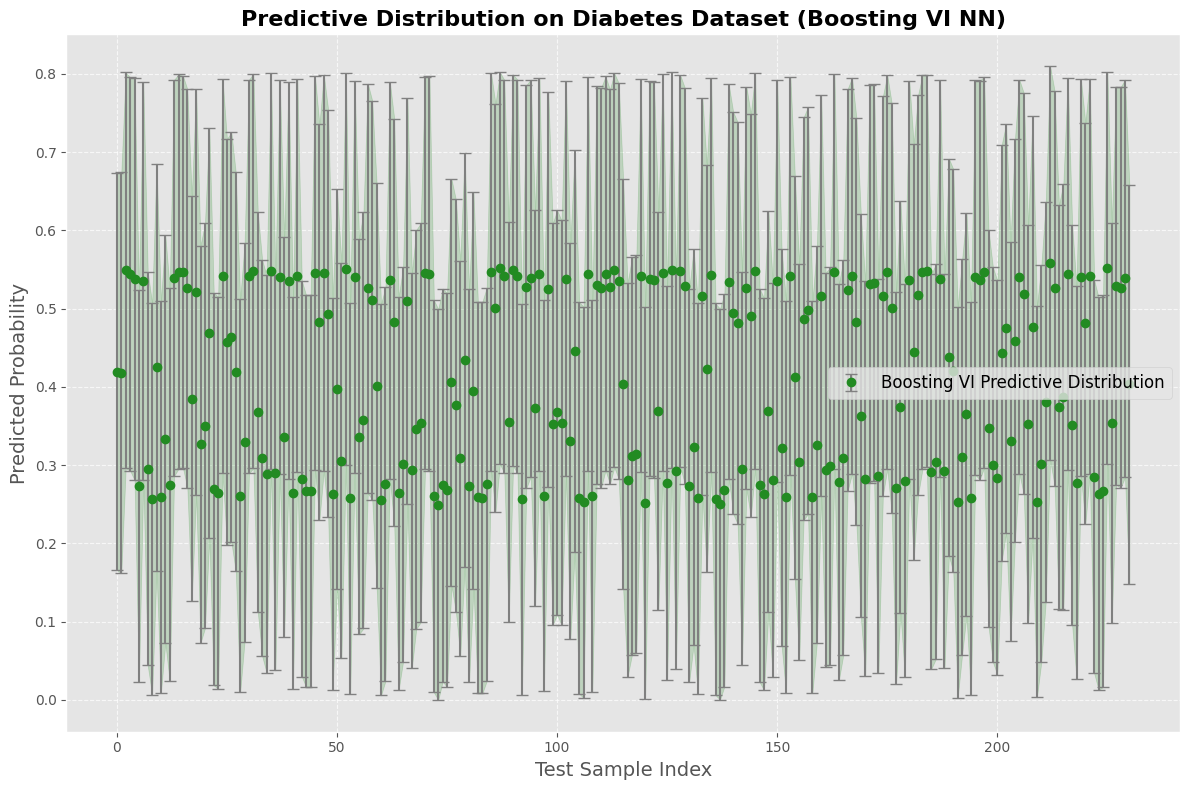

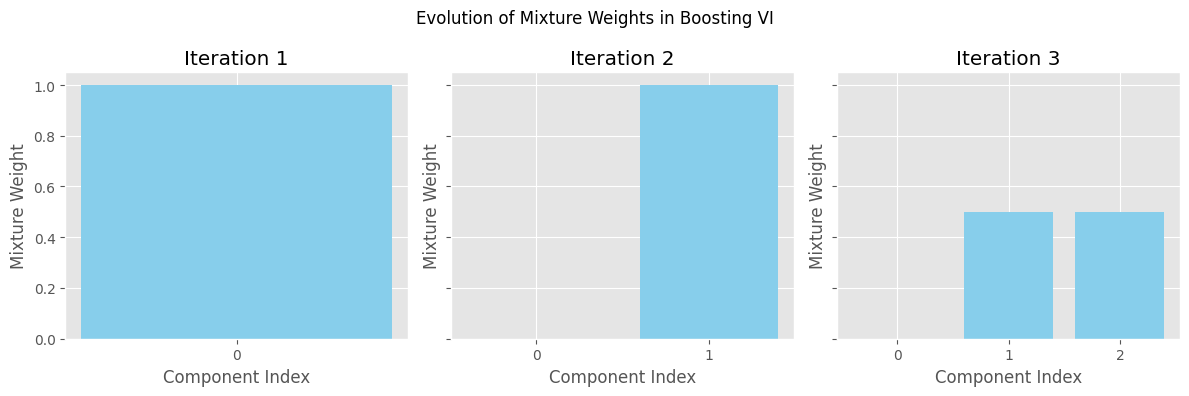

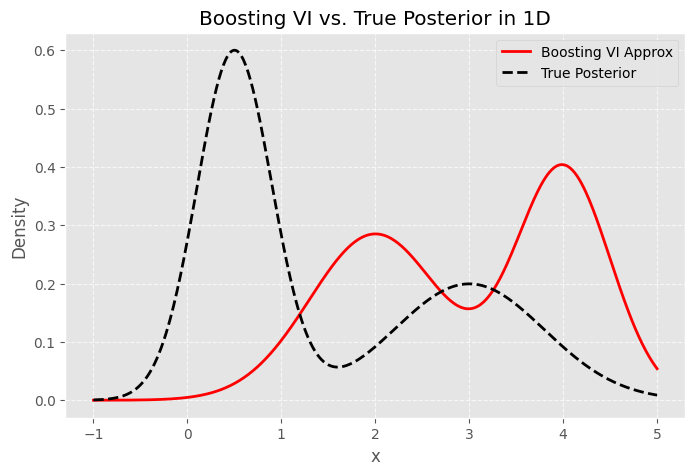

In [52]:
# ------------------------------
# 9. Main Function
# ------------------------------
def main():
    # X, y, input_dim, output_dim = create_dummy_data()
    # print("Data X:\n", X)
    # print("Data y:\n", y)
    file_path = "DataSets/diabetes.csv"
    X, X_test_tensor, y, y_test_tensor, input_dim, output_dim = load_and_preprocess_data(file_path)
    n_iterations = 2  # number of boosting iterations; increase as needed
    start_train_vi = time.time()
    components, weights, mixture_weights_history = train_boosted_model(X, y,input_dim, output_dim, n_iterations=n_iterations, n_steps=2000)
    end_train_vi = time.time()

    print("Training time for BVI NN: {:.4f} seconds".format(end_train_vi - start_train_vi))

    start_infer_vi = time.time()
    evaluate_boosted_model(X, y, components, weights, num_samples=500)
    end_infer_vi = time.time()
    print("Inference time for BVI NN: {:.4f} seconds".format(end_infer_vi - start_infer_vi))
    # plot_mixture_weights(mixture_weights_history)



    # Use the test set tensor for generating the predictive distribution graph
    x_test_tensor_for_graph = X_test_tensor  # Already a tensor from load_and_preprocess_data
    num_samples_graph = 1000  # Number of Monte Carlo samples for smoother estimates
    ensemble_samples = []  # Will store one ensemble sample per MC iteration

    for i in range(num_samples_graph):
        # Initialize an empty tensor for the ensemble prediction
        ensemble_pred = torch.zeros(x_test_tensor_for_graph.shape[0])
        # For each component in the ensemble, generate one sample and weight it accordingly
        for comp, weight in zip(components, weights):
            # Use Predictive with num_samples=1 to get one sample from the current component
            predictive = Predictive(BoostingVINN.model, guide=comp, num_samples=1)
            # "logits" is registered as deterministic in the model so we can retrieve it
            sample = predictive(x_test_tensor_for_graph)["logits"].squeeze()  # shape: [batch_size]
            prob_sample = torch.sigmoid(sample)  # Convert logits to probability
            ensemble_pred += weight * prob_sample
        ensemble_samples.append(ensemble_pred)
    ensemble_samples = torch.stack(ensemble_samples)  # shape: [num_samples_graph, batch_size]

    # Compute the mean and standard deviation for each test sample
    pred_mean = ensemble_samples.mean(dim=0).detach().numpy()
    pred_std = ensemble_samples.std(dim=0).detach().numpy()

    # Plot the predictive distribution with enhanced aesthetics
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 8))
    x_axis = np.arange(len(pred_mean))
    plt.errorbar(x_axis, pred_mean, yerr=pred_std, fmt='o', 
                 color='forestgreen', ecolor='gray', capsize=4, label='Boosting VI Predictive Distribution')
    plt.fill_between(x_axis, pred_mean - pred_std, pred_mean + pred_std, 
                     color='forestgreen', alpha=0.2)
    plt.xlabel('Test Sample Index', fontsize=14)
    plt.ylabel('Predicted Probability', fontsize=14)
    plt.title('Predictive Distribution on Diabetes Dataset (Boosting VI NN)', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



    # 1) Plot the evolution of mixture weights
    plot_mixture_weights_evolution(mixture_weights_history)

    # 2) Plot a 1D mixture approximation vs. a true distribution
    #    ONLY IF you have a 1D scenario with known (mu, sigma) per component.
    #    In a typical classification problem, you won't have these.
    
    # Example: Suppose after final iteration, you have 3 components:
    final_weights = mixture_weights_history[-1].detach().cpu().numpy()  # e.g. [0.4, 0.4, 0.2]
    components_params = [
        (0.0, 0.5),  # mu=0, sigma=0.5
        (2.0, 0.7),  # mu=2, sigma=0.7
        (4.0, 0.5),  # mu=4, sigma=0.5
    ]

    # If you have an analytical true posterior, define it here:
    def true_dist_fn(x):
        # Example: mixture of two Gaussians
        pdf1 = 0.6 * (1.0 / (0.4 * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - 0.5)/0.4)**2)
        pdf2 = 0.4 * (1.0 / (0.8 * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - 3.0)/0.8)**2)
        return pdf1 + pdf2

    # Then call:
    plot_1d_boosting_vi(
        components_params=components_params,
        weights=final_weights,
        true_dist_fn=true_dist_fn,
        x_min=-1, x_max=5
    )

    

    

if __name__ == "__main__":
    main()


In [53]:
# 1. just run 
# 2. run for 16 hidden layers
# 3. run for booting 3